# Imports

In [1]:
import sys
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit

from minot.ClusterTools import map_tools
import pitszi

# Data and parameters

In [2]:
# Cluster parameters
redshift = 0.5458
M500 = 1e15*u.Msun
RA = 109.3875*u.deg
Dec = 37.7541666667*u.deg

# Analysis parameters
elliptical_model = False
beam_FWHM = 18*u.arcsec
smooth_FWHM = 10*u.arcsec

# Constants and usefull values
sigma2fwhm = 2 * np.sqrt(2*np.log(2))

# Extract the input data

In [3]:
#===== Extract the data
# Data image
hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/MAP150GHz_MACSJ0717.fits')
data_ini  = hdul[0].data /(-12.0)*1e-3
data_head = hdul[0].header

# Point source model
hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/PointSourceModel150GHz_MACSJ0717.fits')
data_ps = hdul[0].data /(-12.0)*1e-3
data_img = data_ini - data_ps

# Noise
hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/NoiseMC150GHz_MACSJ0717.fits')
noise = hdul[1].data/(-12.0)*1e-3
rms = np.std(noise, axis=2)
rms_sm = np.std(gaussian_filter(noise, sigma=(smooth_FWHM.to_value('deg')/sigma2fwhm/data_head['CDELT2'], 
                                              smooth_FWHM.to_value('deg')/sigma2fwhm/data_head['CDELT2'], 0)), axis=2)

# Mask
mask = rms_sm*0+1
mask[gaussian_filter(rms_sm,sigma=5)>2*np.amin(gaussian_filter(rms_sm,sigma=5))] = 0

# Transfer function
hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2016_12_Edge_Search/Save/Products/TransferFunction150GHz_MACSJ0717.fits')
data_TF = hdul[1].data
TF = {'k':data_TF['WAVE_NUMBER_ARCSEC'][0]*u.arcsec**-1, 'TF':data_TF['TF'][0]}
Beam_k = pitszi.utils.beam_wf_mn(data_TF['WAVE_NUMBER_ARCSEC'][0], beam_FWHM.to_value('arcsec'))

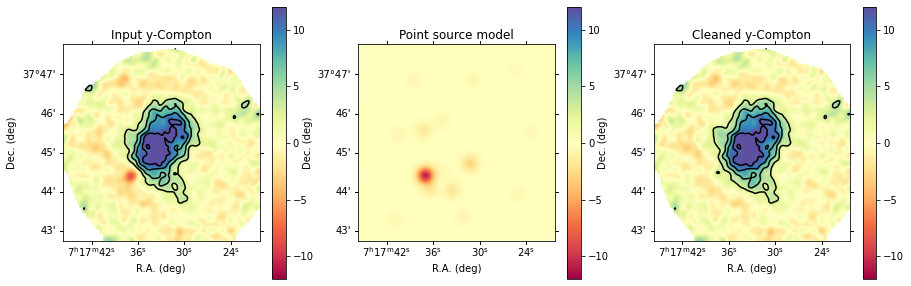

In [4]:
# Show the data
mask_show = mask*1
mask_show[mask_show == 0] = np.nan
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(15, 5))

ax = plt.subplot(1, 3, 1, projection=WCS(data_head))
plt.imshow(mask_show*gaussian_filter(data_ini, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/data_head['CDELT2'])*1e5, cmap='Spectral', vmin=-12, vmax=12)
cb = plt.colorbar()
plt.contour(mask*gaussian_filter(data_ini, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/data_head['CDELT2'])/rms_sm, levels=[3,6,9,12,15,18], colors='k')
plt.title('Input y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 3, 2, projection=WCS(data_head))
plt.imshow(gaussian_filter(data_ps, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/data_head['CDELT2'])*1e5, cmap='Spectral', vmin=-12, vmax=12)
cb = plt.colorbar()
plt.title('Point source model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 3, 3, projection=WCS(data_head))
plt.imshow(mask_show*gaussian_filter(data_img, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/data_head['CDELT2'])*1e5, cmap='Spectral', vmin=-12, vmax=12)
cb = plt.colorbar()
plt.contour(mask*gaussian_filter(data_img, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/data_head['CDELT2'])/rms_sm, levels=[3,6,9,12,15,18], colors='k')
plt.title('Cleaned y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

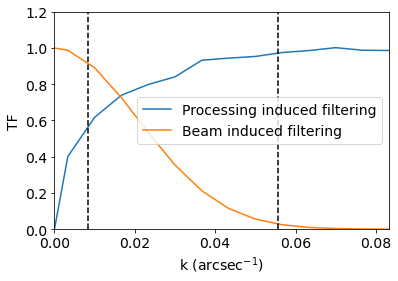

In [5]:
# Show the filtering
plt.rcParams.update({'font.size': 14})
plt.plot(TF['k'], TF['TF'], label='Processing induced filtering')
plt.plot(TF['k'], Beam_k, label='Beam induced filtering')
plt.axvline(1/2/60.0, color='k', ls='--')
plt.axvline(1/beam_FWHM.to_value('arcsec'), color='k', ls='--')
plt.xlabel('k (arcsec$^{-1}$)')
plt.ylabel('TF')
plt.xlim(0, 1/beam_FWHM.to_value('arcsec')*1.5)
plt.ylim(0,1.2)
plt.legend()

# Define the model

In [6]:
# Model definition
cluster = pitszi.Model(RA=RA, Dec=Dec, redshift=redshift, M500=M500, silent=True)

# As a first guess, set to the A10 Morphologically disturbed model
cluster.set_pressure_profile_universal_param('A10MD')

# At first, assumes a standard Pk3D
cluster.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                      'Norm': 0.5, 
                                      'slope': -11/3.0,
                                      'Linj': 1*u.Mpc,
                                      'Ldis': 1*u.kpc}

# Sperical cluster as first guess
cluster.triaxiality = {'min_to_maj_axis_ratio':1, 'int_to_maj_axis_ratio':1,
                       'euler_angle1':0*u.deg, 'euler_angle2':0*u.deg, 'euler_angle3':0*u.deg}
        
cluster.map_header = data_head
cluster.los_reso  = 20*u.kpc
cluster.los_size  = 5*u.Mpc
cluster.R_truncation = cluster.R500*5

seed = None

print('')
print('----- Scale -----')
print('Pixel size in kpc: ', cluster.get_map_reso(physical=True))
print('FoV in Mpc: ', cluster.get_map_fov(physical=True))


----- Scale -----
Pixel size in kpc:  13.156185152365074 kpc
FoV in Mpc:  [1986.58395801 1986.58395801] kpc


# Fit the smooth model to the data

In [7]:
#===== Fitting function
def fitfunc(xdata, 
            par0,
            par1, par2, par3,
            par4, par5):#, 
            #par6, par7):
    
    # Force silent
    cluster.silent = False
    
    # Set the pressure profile
    cluster.model_pressure_profile = {'name': 'beta',
                                      'n_0': par1*u.keV*u.cm**-3,
                                      'r_c': par2*u.kpc,
                                      'beta': par3}
    
    # Only assume a ellipticity along the plane of the sky
    cluster.triaxiality = {'min_to_maj_axis_ratio':par4, 'int_to_maj_axis_ratio':par4,
                       'euler_angle1':0*u.deg, 'euler_angle2':90*u.deg, 'euler_angle3':par5*u.deg}
    
    # Set the offset
    #cluster.coord = SkyCoord(RA+par6*u.deg, Dec+par7*u.deg, frame='icrs')
    
    # Compute the map
    model = cluster.get_sz_map(no_fluctuations=True)
    
    # Convolve with beam and transfer function
    model = pitszi.utils.apply_transfer_function(model, cluster.get_map_reso().to_value('arcsec'), 
                                                 beam_FWHM.to_value('arcsec'), TF, 
                                                 apps_TF_LS=True, apps_beam=True)
    
    # Zero level component
    model = model + par0
    
    return np.reshape(model, model.size)

In [8]:
#===== SZ fit for the processed data
xdata = np.zeros(1)
p0 = [0.05, 300, 0.75, 1, 0]#, 0, 0]

bounds = ([0,      0,      -np.inf, 0, -90],#, -np.inf, -np.inf],
          [np.inf, np.inf, +np.inf, 1, +90])#, +np.inf, +np.inf])
popt_s, pcov = curve_fit(fitfunc, xdata, np.reshape(data_img, data_img.size), 
                         p0=p0, #sigma=np.reshape(rms, rms.size), absolute_sigma=False,
                         bounds=bounds)
print(popt_s)

Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Sett

Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Setting silent value
Setting model_pressure_profile value
Fixing: R500 if involved
Sett

In [9]:
#===== Set the cluster to best fit
cluster.model_pressure_profile = {'name': 'beta',
                                  'n_0': popt_s[0]*u.keV*u.cm**-3,
                                  'r_c': popt_s[1]*u.kpc,
                                  'beta': popt_s[2]}

cluster.triaxiality = {'min_to_maj_axis_ratio':popt_s[3], 'int_to_maj_axis_ratio':popt_s[3],
                       'euler_angle1':0*u.deg, 'euler_angle2':90*u.deg, 'euler_angle3':popt_s[4]*u.deg}

#cluster.coord = SkyCoord((dat_head['CRVAL1']+popt_s[5])*u.deg, 
#                         (dat_head['CRVAL2']+popt_s[6])*u.deg, frame='icrs')

best_model = cluster.get_sz_map(no_fluctuations=True)
best_model_conv = pitszi.utils.apply_transfer_function(best_model, cluster.get_map_reso().to_value('arcsec'), 
                                                       beam_FWHM.to_value('arcsec'), TF, 
                                                       apps_TF_LS=True, apps_beam=True)
best_model_beam = pitszi.utils.apply_transfer_function(best_model, cluster.get_map_reso().to_value('arcsec'), 
                                                       beam_FWHM.to_value('arcsec'), TF, 
                                                       apps_TF_LS=False, apps_beam=True)

Setting model_pressure_profile value
Fixing: R500 if involved


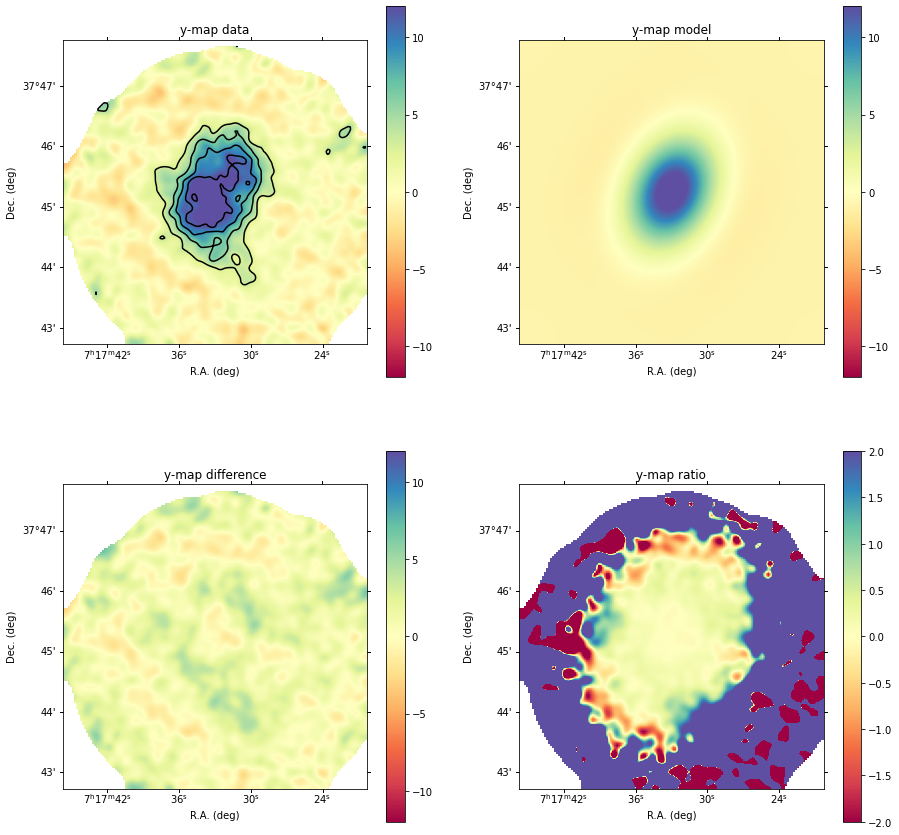

In [10]:
data_img_sm = gaussian_filter(data_img, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/data_head['CDELT2'])
model_img_sm = gaussian_filter(best_model_conv, sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/data_head['CDELT2'])
                
#===== Show the residual
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(15, 15))
ax = plt.subplot(2, 2, 1, projection=WCS(data_head))
plt.imshow(mask_show*data_img_sm*1e5, cmap='Spectral', vmin=-12, vmax=12)
cb = plt.colorbar()
plt.contour(mask*data_img_sm/rms_sm, levels=[3,6,9,12,15,18], colors='k')
plt.title('y-map data')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2, 2, 2, projection=WCS(data_head))
plt.imshow(model_img_sm*1e5, cmap='Spectral', vmin=-12, vmax=12)
cb = plt.colorbar()
plt.title('y-map model')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2, 2, 3, projection=WCS(data_head))
plt.imshow(mask_show*(data_img_sm-model_img_sm)*1e5, cmap='Spectral', vmin=-12, vmax=12)
cb = plt.colorbar()
plt.title('y-map difference')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2, 2, 4, projection=WCS(data_head))
plt.imshow(mask_show*gaussian_filter((data_img-best_model_conv)/best_model_beam,sigma=2), cmap='Spectral', vmin=-2, vmax=2)
cb = plt.colorbar()
plt.title('y-map ratio')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# Extract the 3d power spectrum

# Forward fit of the power spectrum parameters

In [14]:
image = data_img - best_model_conv

k2d, pk2d  = pitszi.utils.extract_pk2d(image, cluster.get_map_reso(physical=True).to_value('kpc'),
                            Nbin=50, kmin=None, kmax=None, scalebin='lin', kedges=None,
                            statistic='mean')
k2d, pk2d

(array([0.00103225, 0.00209001, 0.00314777, 0.00420552, 0.00526328,
        0.00632103, 0.00737879, 0.00843654, 0.0094943 , 0.01055206,
        0.01160981, 0.01266757, 0.01372532, 0.01478308, 0.01584083,
        0.01689859, 0.01795634, 0.0190141 , 0.02007186, 0.02112961,
        0.02218737, 0.02324512, 0.02430288, 0.02536063, 0.02641839,
        0.02747614, 0.0285339 , 0.02959166, 0.03064941, 0.03170717,
        0.03276492, 0.03382268, 0.03488043, 0.03593819, 0.03699595,
        0.0380537 , 0.03911146, 0.04016921, 0.04122697, 0.04228472,
        0.04334248, 0.04440023, 0.04545799, 0.04651575, 0.0475735 ,
        0.04863126, 0.04968901, 0.05074677, 0.05180452, 0.05286228]),
 array([2.38194529e-05, 5.43855347e-06, 2.12788505e-06, 1.92642936e-06,
        1.40587770e-06, 1.54979044e-06, 1.45703507e-06, 1.08468207e-06,
        1.41945163e-06, 1.55223887e-06, 1.40970668e-06, 1.51630883e-06,
        1.59953555e-06, 1.49469578e-06, 1.26217831e-06, 1.24854068e-06,
        1.21546829e-06, 1.1320

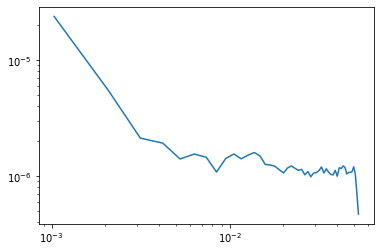

In [17]:
#plt.loglog(k2d, np.sqrt(2*np.pi*k2d**2*pk2d))
plt.loglog(k2d, pk2d)